In [1]:
from tensorflow import keras
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
from IPython.display import Audio

In [5]:
os.listdir('./')

#model = keras.models.load_model('../bin/rnn_model1.2')

['preprocessing.ipynb',
 'inference.ipynb',
 'bin',
 'data',
 '.ipynb_checkpoints',
 'training_model.ipynb']

In [ ]:
AUDIO_FILES = "../data/audio_files/"
audio_files_list = listdir(AUDIO_FILES)
SR = 16000


In [ ]:
def splitFile(audio_file):
    audio_list = []
    index = 0
    counter = 0
    for i in np.arange(SR*10, audio_file.shape[0], SR*10):
        audio_list.append(audio_file[index:i])
        index=i
        counter += 1
    return(audio_list)

def featureExtraction(signal):
    mfccs = librosa.feature.mfcc(y=signal, n_mfcc=13, sr=SR, hop_length=160)
    # delta_mfccs = librosa.feature.delta(mfccs)
    # delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    # comprehensive_mfccs = np.concatenate(mfccs, delta_mfccs, delta2_mfccs)
    targets = mfccs.transpose()[1:]
    return mfccs.transpose()[:-1], targets
    

In [ ]:
test_files = ['5.06-_The_Abdications_of_Bayonne_Master.mpga',
 '8.3-_The_Government_of_National_Defence_Master.mpga',
 '10.23-_On_Agitation_Master.mpga',
 '3.17-_A_Temporary_Summit.mpga',
 '015-_The_Good_Old_Cause.mpga',
 '003-_The_Bishops_Wars.mpga',
 '4.19-_The_History_of_Haiti_Master.mpga',
 '10.91-_The_Battle_of_Warsaw_Master.mpga',
 '6.05-_The_Barricades_Master.mpga',
 '8.7-_Year_79_1.mpga']

In [266]:
signal, sr = librosa.load(AUDIO_FILES + test_files[0])
signal = librosa.resample(signal, orig_sr=sr, target_sr=SR)

signal.shape

/opt/conda/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


(41140559,)

In [275]:
clip_list = splitFile(signal)

In [314]:
test_clip = clip_list[31]
Audio(test_clip, rate=SR)

In [315]:
# Predict next timestep for each timestep
features, targets = featureExtraction(test_clip)
features = np.expand_dims(features, axis=0)
result = model.predict(features)

1/1 [==============================] - 0s 101ms/step


In [316]:
# Make lists of vectors for predicted and targets
predict_list = []
target_list = []
for i in result:    
    for j in i:
        predict_list.append(j)
for i in targets:
    target_list.append(i)
    
print(len(predict_list))
print(len(target_list))

# Make a list of cosine similarities
cos_sim = []
from scipy import spatial
for i in range(len(predict_list)):
    cos_sim.append(1 - spatial.distance.cosine(predict_list[i], target_list[i]))

print(len(cos_sim))

1000
1000
1000


<Figure size 1296x360 with 0 Axes>

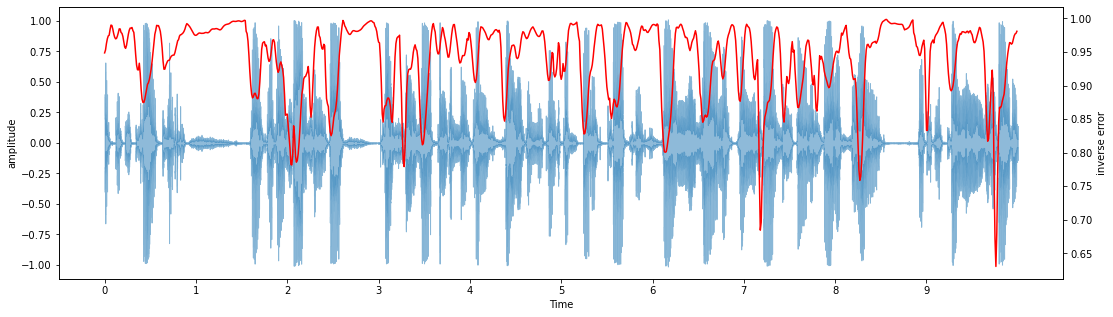

In [317]:
# create figure and axis objects with subplots()
plt.figure(figsize=(18,5))

fig,ax = plt.subplots(figsize=(18,5))
librosa.display.waveshow(test_clip, sr=16000, ax=ax, alpha=0.5)
ax.set_ylabel('amplitude')
ax2=ax.twinx()
ax2.plot(np.arange(0,10,10/len(cos_sim)), cos_sim, color='red')
ax2.set_ylabel('inverse error')
plt.xticks(range(10))
plt.show()

In [420]:


def makeLabelList(cos_sim_list):
    anomalies = []
    label_list = []
    
    for i in range(len(cos_sim_list)):
        if i == 0:
            continue
        elif cos_sim[i-1] - cos_sim[i] > 0.01:
            anomalies.append(i)    

    counter = 0        
    print(len(anomalies))
    for i in range(len(anomalies)):
        streak_list = [anomalies[i]]
        c = i
        while c < len(anomalies):
            if c+2 > len(anomalies):
                break
            
            elif anomalies[c+1] == anomalies[c]+1:
                streak_list.append(anomalies[c+1])
                c += 1
            else:
                break
        label_list.append(streak_list)
    
    items_to_pop = []
    for i in range(len(label_list)):
        if i == 0:
            continue
        elif label_list[i] == label_list[i-1][1:]:
            items_to_pop.append(i)
    
    almost_final_list = [elem for i,elem in enumerate(label_list) if i not in items_to_pop]
    final_list = [(i[0], i[-1]) for i in almost_final_list]
    
    return final_list

text_string = ''

for beginning, end in makeLabelList(cos_sim):
    text_string += str(beginning*0.01) + '\t' + str(end*0.01) + ',\n'
print(text_string)
with open('../data/clip2_labels.txt', 'w') as f:
    f.write(text_string)

155
0.33	0.35000000000000003,
0.39	0.41000000000000003,
0.62	0.65,
1.55	1.55,
1.57	1.61,
1.87	1.8900000000000001,
1.96	1.98,
2.0100000000000002	2.04,
2.08	2.1,
2.24	2.2600000000000002,
2.35	2.35,
2.42	2.43,
2.46	2.47,
3.02	3.0500000000000003,
3.14	3.14,
3.24	3.27,
3.43	3.47,
3.63	3.64,
3.87	3.88,
4.01	4.05,
4.34	4.37,
4.82	4.8500000000000005,
4.92	4.92,
4.99	4.99,
5.03	5.03,
5.19	5.19,
5.21	5.25,
5.46	5.51,
5.54	5.54,
6.07	6.13,
6.49	6.5200000000000005,
6.54	6.54,
6.74	6.76,
6.91	6.95,
7.08	7.11,
7.16	7.18,
7.390000000000001	7.43,
7.54	7.54,
7.5600000000000005	7.59,
7.72	7.75,
7.78	7.79,
7.88	7.88,
8.13	8.15,
8.18	8.19,
8.23	8.27,
8.86	8.86,
8.98	9.0,
9.22	9.25,
9.63	9.67,
9.73	9.76,



In [325]:
list(range(4, 8))

[4, 5, 6, 7]

In [319]:
import soundfile as sf
sf.write('../data/clip2.wav', test_clip, 16000)

### Look at the raw waveform

Text(0.5, 1.0, 'Raw Waveform')

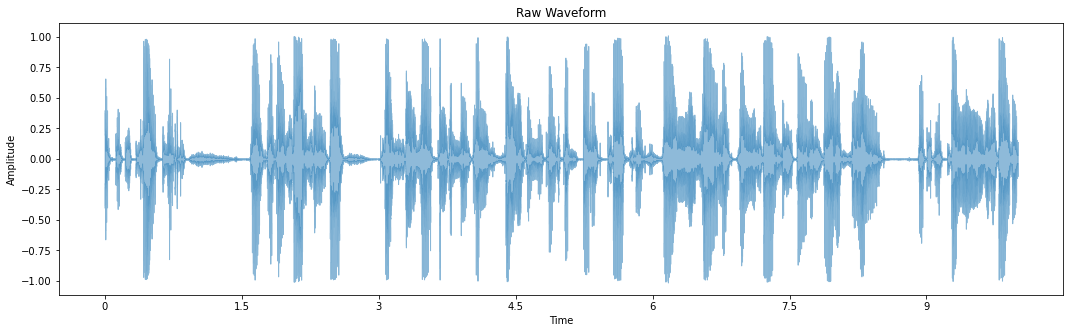

In [421]:
plt.figure(figsize=(18,5))
librosa.display.waveshow(test_clip, sr=16000, alpha=0.5)
plt.ylabel('Amplitude')
plt.title('Raw Waveform')

(1024, 101)


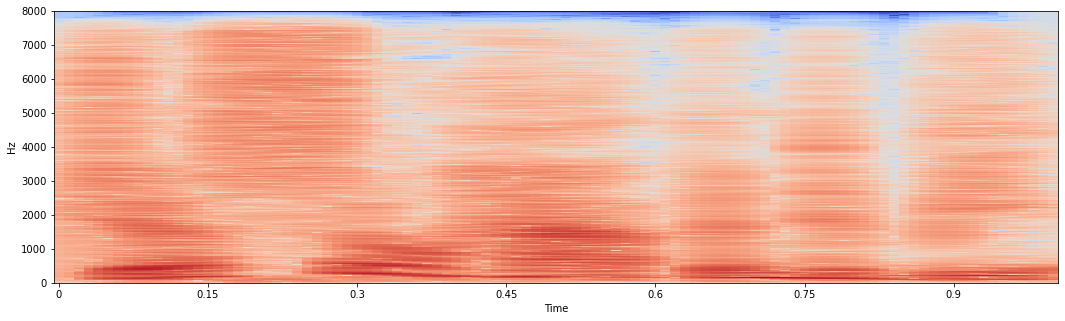

In [456]:
# plt.figure(figsize=(18,5))
plt.figure(figsize=(18,5))

hop_length=160
spectrogram = librosa.stft(test_clip[3*SR:3*SR+16000], n_fft=2046, hop_length= hop_length)
print(spectrogram.shape)
#plt.plot(np.fft.ifft(np.log(abs(spectrogram.transpose()[200][:800]))))
librosa.display.specshow(librosa.power_to_db(spectrogram), y_axis='linear', x_axis='time', hop_length=hop_length, sr=SR)
plt.show()



# plt.plot(np.abs(spectrogram[100]))

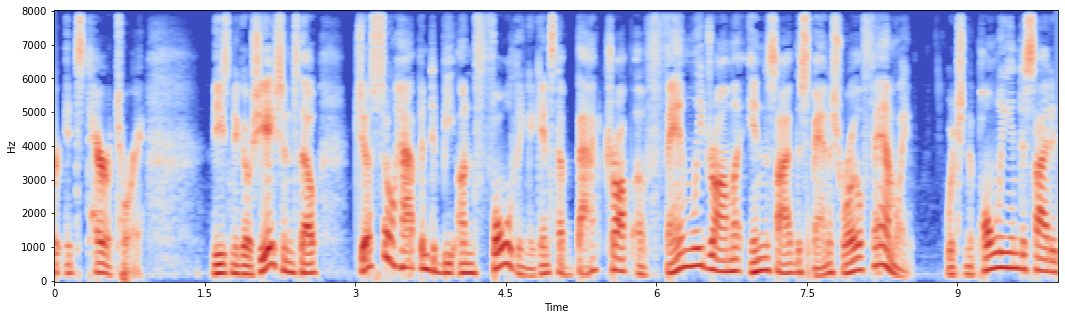

In [458]:
plt.figure(figsize=(18,5))
mel_spectrogram = librosa.feature.melspectrogram(y=test_clip, sr=SR, n_fft=2046, hop_length=hop_length)
# print(mel_spectrogram.shape)
# plt.plot(np.fft.ifft(librosa.power_to_db(mel_spectrogram).transpose()[300][:80])
librosa.display.specshow(librosa.power_to_db(mel_spectrogram), y_axis='linear', x_axis='time', hop_length=hop_length, sr=SR)


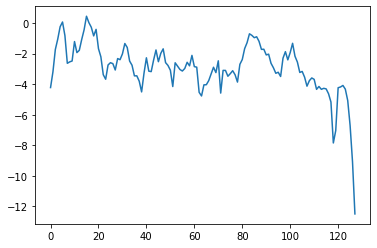

In [194]:
plt.plot(np.log(mel_spectrogram.transpose()[100]))

In [443]:
window = test_clip[SR*2:SR*2+1600]

In [444]:
def plot_magnitude_spectrum(signal, title, sr, f_ratio=1):
    ft = np.fft.fft(signal)
    magnitude_spectrum = np.abs(ft)
    
    plt.figure(figsize=(18,5))
    
    frequency = np.linspace(0, sr, len(magnitude_spectrum))
    num_frequency_bins = int(len(frequency) * f_ratio)
    
    plt.plot(frequency[:num_frequency_bins], magnitude_spectrum[:num_frequency_bins])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.title(title)
    
    plt.show

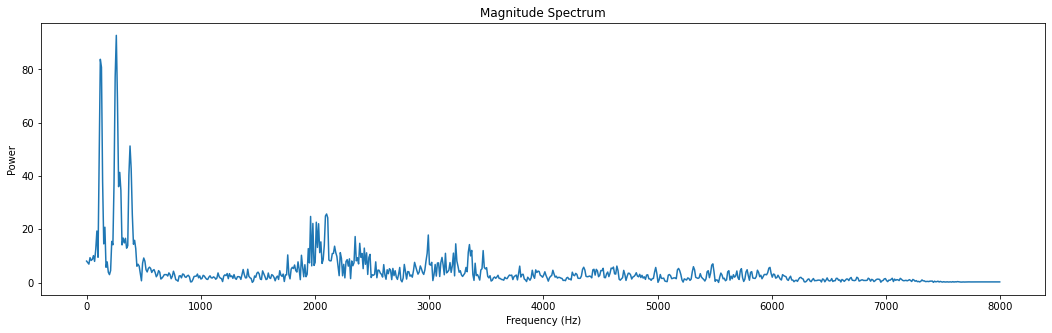

In [445]:
plot_magnitude_spectrum(window, 'Magnitude Spectrum', SR, f_ratio=0.5)

In [453]:
def plot_log_spectrum(signal, title, sr, f_ratio=1):
    ft = np.fft.fft(signal)
    magnitude_spectrum = np.abs(ft)
    log_power_spectrum = np.log(magnitude_spectrum)
    envelope = np.abs(magnitude_spectrum)
    
    
    plt.figure(figsize=(18,5))
    
    frequency = np.linspace(0, sr, len(log_power_spectrum))
    num_frequency_bins = int(len(frequency) * f_ratio)
    
    plt.plot(frequency[:num_frequency_bins], log_power_spectrum[:num_frequency_bins])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(title)
    
    plt.show

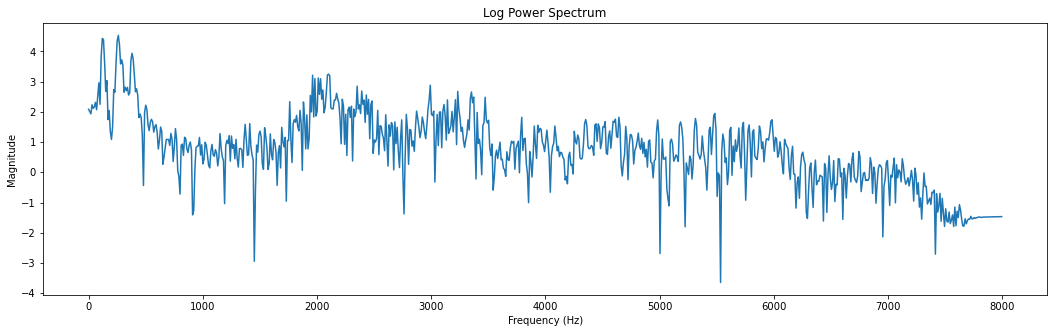

In [454]:
plot_log_spectrum(window, 'Log Power Spectrum', SR, f_ratio=0.5)

In [448]:
def plot_cepstrum(signal, title, sr, f_ratio=1):
    ft = np.fft.fft(signal)
    magnitude_spectrum = np.abs(ft)
    log_power_spectrum = np.log(magnitude_spectrum)
    cepstrum = np.abs(np.fft.ifft(log_power_spectrum)[2:])
    
    plt.figure(figsize=(18,5))
    
    frequency = np.linspace(0, sr, len(cepstrum))
    num_frequency_bins = int(len(frequency) * f_ratio)
    
    plt.plot(frequency[:num_frequency_bins], cepstrum[:num_frequency_bins])
    plt.xlabel('Quefrency')
    plt.ylabel('Absolute Magnitude')
    plt.title(title)
    
    plt.show

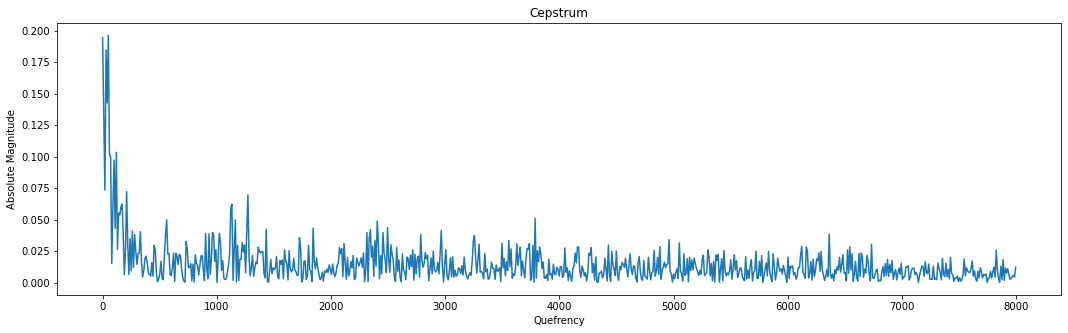

In [450]:
plot_cepstrum(window, 'Cepstrum', SR, f_ratio=0.5)

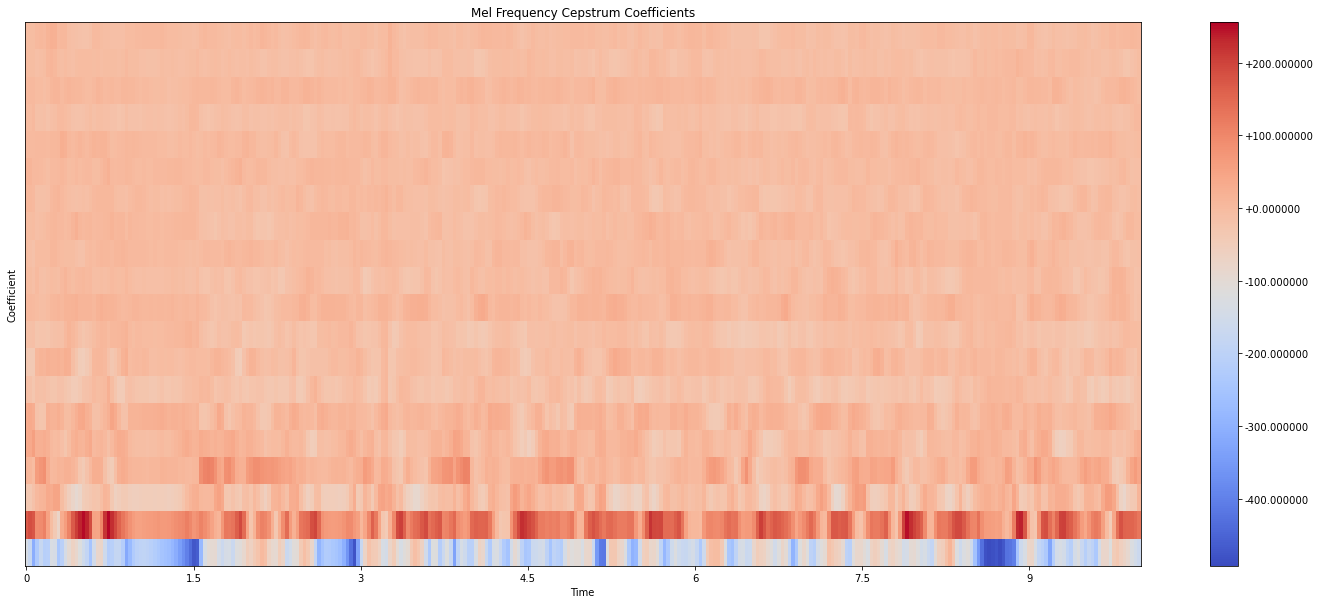

In [463]:
melspec = librosa.feature.melspectrogram(y=test_clip, sr=SR, hop_length=hop_length)

plt.figure(figsize=(25,10))
librosa.display.specshow(MFCCs,
                         x_axis="time",
                         sr = SR)
plt.colorbar(format='%+2f')
plt.title('Mel Frequency Cepstrum Coefficients')
plt.xlabel('Time')
plt.ylabel('Coefficient')
plt.show()

In [468]:
melspec = librosa.feature.melspectrogram(y=test_clip, sr=SR, hop_length=hop_length)
melspec[50][:].shape

(1001,)

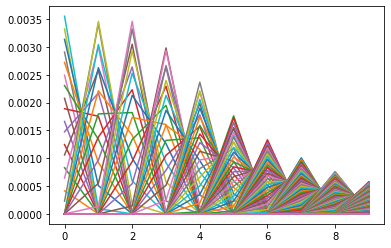

In [472]:
import librosa
import matplotlib.pyplot as plt

sr = 16000
mel_basis = librosa.filters.mel(sr=sr, n_fft=512, n_mels=10,fmin=0, fmax=sr / 2)
plt.plot(mel_basis)
plt.show()

In [291]:
Audio(data=test_clip, rate=SR)

AttributeError: 'AdaptiveWaveplot' object has no attribute 'twiny'

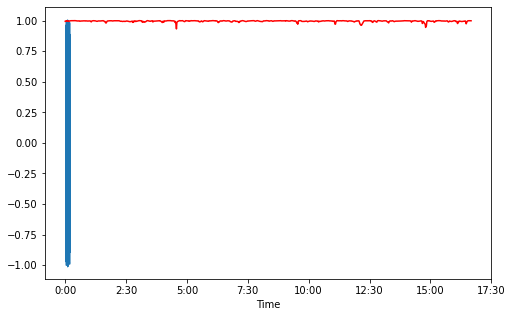

In [77]:
# Plot two lines with different scales on the same plot
fig = plt.figure(figsize=(8, 5))
line_weight = 3
alpha = .5
ax1 = librosa.display.waveshow(test_clip, sr=16000)
ax2 = plt.plot(cos_sim, color='red')
ax2 = ax1.twiny()
        
plt.show()